In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm
import random

# Fonctions

## Fonctions liées à l'ajout de gris à une image

In [2]:
def tograyscale(mat):
    """
    Scale les nombres de la matrice dans [0,255] (pour permettre les images en nuance de gris)
    Mais ne prend pas encore en compte le négatif
    """
    scaled_mat = 255.0 * mat / mat.max()
    #scaled_mat[scaled_mat<0] = 0 ?
    return scaled_mat

In [3]:
def to_binary(filename):
    """
    Importation de l'image, passage en nuance de gris, puis passage dans {0,1}
    """
    my_img = Image.open(filename)
    img_gray = ImageOps.grayscale(my_img) # Conversion en nuances de gris
    img_gray = np.array(img_gray)
    img_gray_binary = np.where(img_gray > 0.5, 1, 0) #Passage en binaire (méthodologie douteuse)
    return img_gray_binary


In [4]:
def noise(img, TAU, MU):
    """
    Ajout d'un bruit gaussien aux pixels de l'image
    """
    img_noised = np.zeros(shape = img.shape)
    row, col = np.shape(img)
    for i in range(row):
        for j in range(col):
            # ATTENTION: scale c'est l'écart type et pas la variance !
            img_noised[i,j] = np.random.normal(loc = MU[int(img[i,j])], scale = TAU)
    
    return img_noised

In [5]:
def create_noised_image(img, name, TAU, MU = [0,1]):
    """
    img = chemin vers l'image à bruiter
    name = suffixe de l'image bruitée enregistrée
    TAU = écart-type pour le bruit gaussien
    MU = moyenne pour le bruit gaussien MU[0] = 0, MU[1] = 1 par défaut donc bruit centré
    """
    
    
    img_bin = to_binary(img)
    img_bin_noised = noise(img_bin, TAU, MU)
    plt.imshow(img_bin_noised, cmap = "gray")
    
    tosave = Image.fromarray(tograyscale(img_bin_noised))
    tosave.convert("L").save("data/"+str(name)+"_"+str(TAU)+".png")

## Fonctions liées au gibbs sampling à propos parlé

In [6]:
def sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU):
    """
    Echantillonne dans la distribution conditionnelle pour un pixel
    """
   
    # Ajout des valeurs des 4 voisins du pixel considéré, si pertinent
    voisins = []
    if i != 0:
        voisins.append(X[i-1][j])
    if i!= maxi-1:
        voisins.append(X[i+1][j])
    if j!= 0:
        voisins.append(X[i][j-1])
    if j!= maxj-1:
        voisins.append(X[i][j+1])
        
    # Calcul du nombre de 0 et de 1 dans les voisins
    nb_0 = sum(voisins[i] == 0 for i in range(len(voisins)))
    nb_1 = sum(voisins[i] == 1 for i in range(len(voisins)))
    
    # Prise en considération de la variation du nombre de voisins (bords)
    pond = 4/len(voisins) 
    
    # Calcul de la probabilité de valoir 1
    exp_valeur_1 = -ALPHA + BETA * pond * (nb_0-nb_1) + 1/(2*(TAU**2))*(MU[1]**2 - MU[0]**2 + 2*Y[i][j]*(MU[0]-MU[1]))
    
    # Calcul de la probabilité de valoir 0 (juste pour vérifier)
    #exp_valeur_0 = ALPHA + BETA * pond * (nb_1-nb_0) + 1/(2*(TAU**2))*(MU[0]**2 - MU[1]**2 + 2*Y[i][j]*(MU[1]-MU[0]))
    #print(1/(1+np.exp(exp_valeur_1)) + 1/(1+np.exp(exp_valeur_0)))
    #print(1/(1+np.exp(exp_valeur_0)))
    
    prob = 1/(1+np.exp(exp_valeur_1))
    
    # Renvoie 1 si l'uniforme est inférieure à la proba de valoir 1
    U = np.random.rand()
    return(int(U < prob)) 

In [10]:
def get_posterior(filename, burn_in, samples, ALPHA, BETA, TAU, deter = True, MU = [0.0,1.0]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    
    Attention, ici l'image qu'on ouvre doit bien être enregistrée en nuances de gris !
    """
    #Y = to_binary(filename) # Chargement de l'image, à changer car l'image n'a ici pas besoin d'être en binaire
    im_open = Image.open(filename)
    Y = np.array(im_open)
    im_open.close()
    
    # Vérification que l'image est bien en nuances de gris ("2D")
    if len(Y.shape) != 2: 
        print("Erreur: l'image n'est pas en nuances de gris")
        return False
    Y = Y / 255.0 #Test
    print(Y)
    
    print("Image bruitée")
    plt.imshow(Y, cmap = "gray") # Affichage de l'image bruitée
    plt.show()
    
    # Initialisation
    posterior = np.zeros(Y.shape) #Sortie
    
    X = np.random.choice([1,0], size = Y.shape) # Matrice X
    print("Prior aléatoire")
    plt.imshow(X, cmap = "gray")
    plt.show()
    
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    pairs = []
    
    for i in range(maxi):
        for j in range(maxj):
            pairs.append((i,j))
    
    
    for step in tqdm(range(burn_in + samples)):
        
        # On parcourt les pixels de manière déterministe (toujours la même)
        if deter:
            for i in range(maxi):
                for j in range(maxj):
                    x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                    X[i,j] = x
                    if x == 1 and step >= burn_in:
                        posterior[i][j] += 1
                        
        # On parcourt les pixels de manière aléatoire
        else:
            random.shuffle(pairs) # On mélange la liste de pairs 
            for i,j in pairs:
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1.0
            
            
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On fait la moyenne
    posterior = posterior / samples
    
    print("Posterior")
    plt.imshow(posterior, cmap = "gray")
    plt.show()

    return posterior

In [8]:
# Cettefonction sert à ce que le posterior soit binarisé (au lieu de prendre des probas issues du sampling)
# Mais est peu utille en l'état

def denoise_image(filename, burn_in, samples, ALPHA, BETA, TAU, MU = [0,1]):
    """
    Ici on considère comme 1 valant 1 les pixels où le posterior 
    vaut 1 à une fréquence supérieure à seuil
    mu = [0,1] par défaut donc pas de biais
    """
    
    posterior = get_posterior(filename, burn_in, samples, ALPHA, BETA, TAU, MU)
    denoised = np.zeros(posterior.shape, dtype=np.float64)
    denoised[posterior > 0.5] = 1 # POur  cpasser des probas à des valeurs 
    
    return denoised

# Tests

In [ ]:
I = 2
J = 2
pairs = []

for i in range(I):
    for j in range(J):
        pairs.append((i,j))
random.shuffle(pairs)
pairs

# Exemple d'affichage d'une image

In [ ]:
og_image = Image.open("data/poke_noise_01_0point1.png")
plt.imshow(og_image, cmap = "gray")
og_array = np.array(og_image)
print(og_array)
og_bis = np.ones(shape = og_array.shape)
og_bis[og_array<1] = 0
plt.imshow(og_bis, cmap = "gray")
og_image.close()

# Tentative de débruitage

In [ ]:
posterior = get_posterior("data/poke_noise.png", 1000, 1000)

[[0.69019608 0.68235294 0.80392157 0.72941176 0.68627451 0.60392157
  0.83921569 0.61568627 0.63921569 0.67843137 0.72156863 0.77254902
  0.69019608 0.71764706 0.84705882 0.58431373]
 [0.69803922 0.68627451 0.65098039 0.67058824 0.71372549 0.7372549
  0.62352941 0.6627451  0.84705882 0.57254902 0.67058824 0.65882353
  0.58039216 0.76078431 0.70980392 0.78431373]
 [0.90196078 0.70588235 0.69803922 0.61960784 0.68627451 0.76862745
  0.         0.         0.10588235 0.03529412 0.73333333 0.80784314
  0.6745098  0.5372549  0.7372549  0.70980392]
 [0.81568627 0.81960784 0.76862745 0.64705882 0.         0.
  0.7254902  0.71764706 0.63137255 0.62352941 0.10980392 0.0745098
  0.77254902 0.70588235 0.82745098 0.69411765]
 [0.78823529 0.60784314 0.62745098 0.02352941 0.81176471 0.52941176
  0.81568627 0.70588235 0.70196078 0.81568627 0.61568627 0.8745098
  0.         0.62745098 0.80392157 0.80392157]
 [0.68235294 0.69803922 0.76470588 0.         0.75294118 0.58431373
  0.81176471 0.69803922 0.61

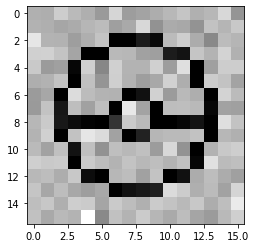

Prior aléatoire


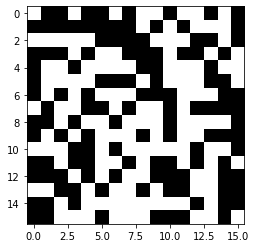

100%|██████████| 1/1 [00:00<00:00, 44.70it/s]


Posterior


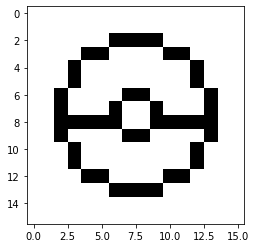

In [11]:
posterior = get_posterior("data/poke_noise_01_0point1.png", 0, 1, ALPHA = 1e-5, BETA = 0.2, TAU = 0.1, 
                          deter = True)

In [17]:
posterior

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,

J'ai pour l'instant l'impression qu'il n'arrive pas à noircir les pixels très légèrement pas noirs, et ce quel que soit le nombre d'itérations.